## Import Libraries

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import empiricaldist
import scipy
import statsmodels.formula.api as smf

## Config

In [46]:
# Settings
sns.set()
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',200)
pd.options.display.float_format= '{:.2f}'.format

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

Title_fontsize= 16

In [47]:
laptop = pd.read_csv('./data/laptop-EDA.csv')
laptop.head()

,Company,TypeName,Inches,Ram,Gpu,OpSys,Weight,Price_euros,screen_width,screen_height,IPS Panel,CPU Brand,CPU GHz,MemoryAmount,MemoryType
0,Apple,Ultrabook,13.30,8,Intel,macOS,1.37,1339.69,2560,1600,1,Intel,2.30,128,SSD
1,Apple,Ultrabook,13.30,8,Intel,macOS,1.34,898.94,1440,900,0,Intel,1.80,128,Flash
2,HP,Notebook,15.60,8,Intel,No OS,1.86,575.00,1920,1080,0,Intel,2.50,256,SSD
3,Apple,Ultrabook,15.40,16,AMD,macOS,1.83,2537.45,2880,1800,1,Intel,2.70,512,SSD
4,Apple,Ultrabook,13.30,8,Intel,macOS,1.37,1803.60,2560,1600,1,Intel,3.10,256,SSD


In [48]:
print('The dataset contain {} rows and {} columns'.format(laptop.shape[0],laptop.shape[1]))

The dataset contain 1303 rows and 15 columns


In [87]:
laptop = (
    laptop.astype({
        'IPS Panel': 'bool'
        })
)

In [88]:
(
    laptop
    .dtypes
    .value_counts()
)

object     6
float64    4
int64      4
bool       1
dtype: int64

In [89]:
def Zerovalues(df):
    d = {'TotalRecord': df.shape[0], '#Zeros':0, '%Zeros':0}
    y = pd.DataFrame(d, index= df.columns)
     
    for c  in df.columns:
         y.loc[c,"#Zeros"] = len(df[df[c]==0])
         y.loc[c,"%Zeros"] = round((y.loc[c,"#Zeros"] / y.loc[c,"TotalRecord"] ),2) * 100
    return y[y["#Zeros"]>0]

Zerovalues(laptop)

,TotalRecord,#Zeros,%Zeros
IPS Panel,1303,938,72


# Univariate Analysis

### Categorical variables - Analysis

In [90]:
laptop.describe(include='object').transpose()

,count,unique,top,freq
Company,1303,9,Dell,297
TypeName,1303,6,Notebook,727
Gpu,1303,4,Intel,722
OpSys,1303,7,Windows 10,1080
CPU Brand,1303,3,Intel,1240
MemoryType,1303,4,SSD,843


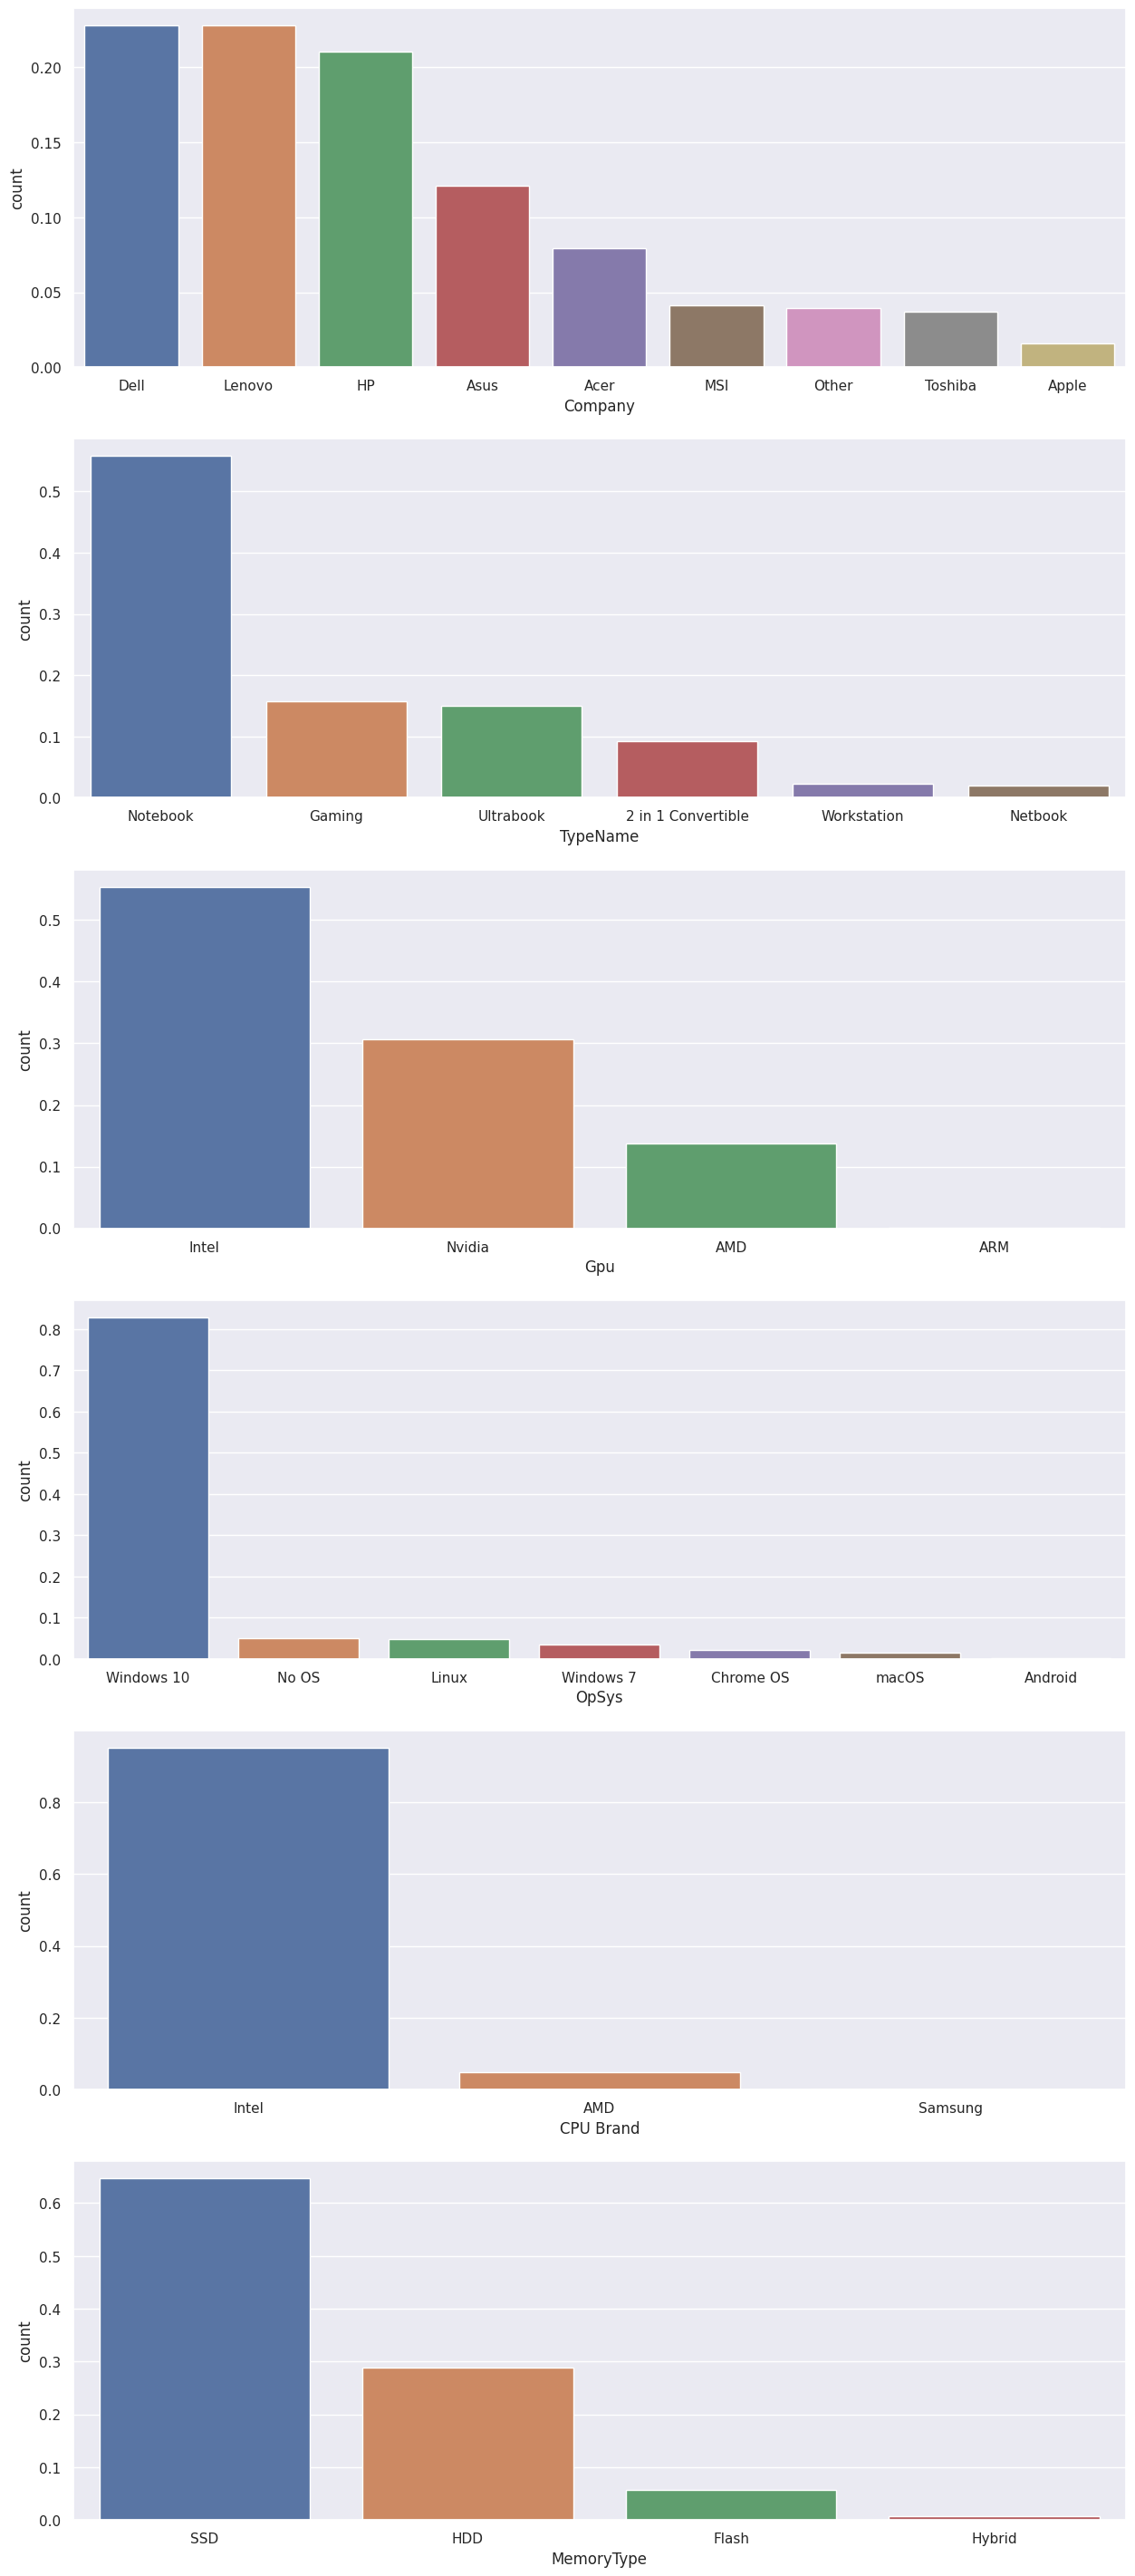

In [91]:
categories=laptop.select_dtypes(include='object').columns
fig, ax = plt.subplots(len(categories),1,figsize=(15,len(categories)*6))
for i in range(len(categories)):
    (
        laptop
        .value_counts(categories[i],sort=True,normalize=True)
        .reset_index(name='count')
        .pipe(
            lambda df_count:(
                sns.barplot(
                    ax=ax[i],
                    data=df_count,
                    x = categories[i],
                    y='count'
                )
            )
                
        )
    )

In [92]:
def pivot_table(data,columns,count):

    for column in columns:
        d = data.pivot_table(index= column, values=count, margins=True,margins_name='Total',aggfunc='count')
        d['%']=d/data.shape[0]
        d['%']=round(d['%'].astype(float),2)
        print(column)
        print('')
        print(d.sort_values(by=count,ascending=True))
        print('\n')

categories = laptop.select_dtypes(include='object')
pivot_table(laptop,categories,'Price_euros')

Company

         Price_euros    %
Company                  
Apple             21 0.02
Toshiba           48 0.04
Other             51 0.04
MSI               54 0.04
Acer             103 0.08
Asus             158 0.12
HP               274 0.21
Dell             297 0.23
Lenovo           297 0.23
Total           1303 1.00


TypeName

                    Price_euros    %
TypeName                            
Netbook                      25 0.02
Workstation                  29 0.02
2 in 1 Convertible          121 0.09
Ultrabook                   196 0.15
Gaming                      205 0.16
Notebook                    727 0.56
Total                      1303 1.00


Gpu

        Price_euros    %
Gpu                     
ARM               1 0.00
AMD             180 0.14
Nvidia          400 0.31
Intel           722 0.55
Total          1303 1.00


OpSys

            Price_euros    %
OpSys                       
Android               2 0.00
macOS                21 0.02
Chrome OS            27 0.0

### Measures of dispersion

In [93]:
laptop.describe(include=np.number).transpose()

,count,mean,std,min,25%,50%,75%,max
Inches,1303.00,15.02,1.43,10.10,14.00,15.60,15.60,18.40
Ram,1303.00,8.38,5.08,2.00,4.00,8.00,8.00,64.00
Weight,1303.00,2.04,0.67,0.69,1.50,2.04,2.30,4.70
Price_euros,1303.00,1123.69,699.01,174.00,599.00,977.00,1487.88,6099.00
screen_width,1303.00,1894.78,494.64,1366.00,1600.00,1920.00,1920.00,3840.00
screen_height,1303.00,1070.83,284.52,768.00,900.00,1080.00,1080.00,2160.00
CPU GHz,1303.00,2.30,0.51,0.90,2.00,2.50,2.70,3.60
MemoryAmount,1303.00,442.62,356.23,8.00,256.00,256.00,512.00,2000.00


In [94]:
def hist_boxplot(df):
    numeric_columns = df.select_dtypes(include=np.number)
    for column in numeric_columns:
        plt.figure(figsize=(11,5))
        sns.histplot(
            data=df,
            x=column,
            stat='probability'
        )
        plt.axvline(
            x=df[column].mean(),
            color='red',
            linestyle='--',
            linewidth=2)
        plt.axvline(
        x= df[column].quantile(q=0.25),
            color='green',
            linestyle='--',
            linewidth=2
        )
        plt.axvline(
        x= df[column].quantile(q=0.75),
            color='green',
            linestyle='--',
            linewidth=2
        )
        plt.title(column+' - Histogram',fontsize=16)
        plt.show()
        plt.figure(figsize=(11,5))
        sns.boxplot(data=df
                    ,x=column)
        plt.title(column+' - Boxplot',fontsize=Title_fontsize)
        plt.show()

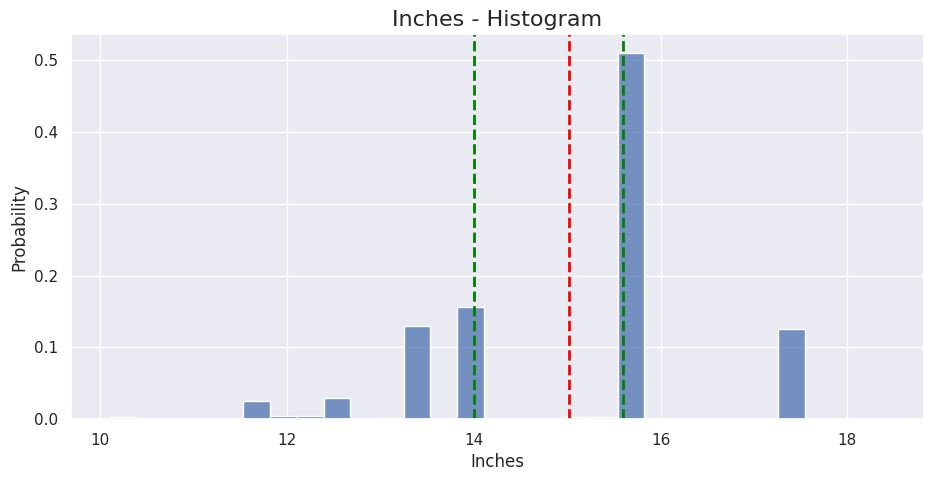

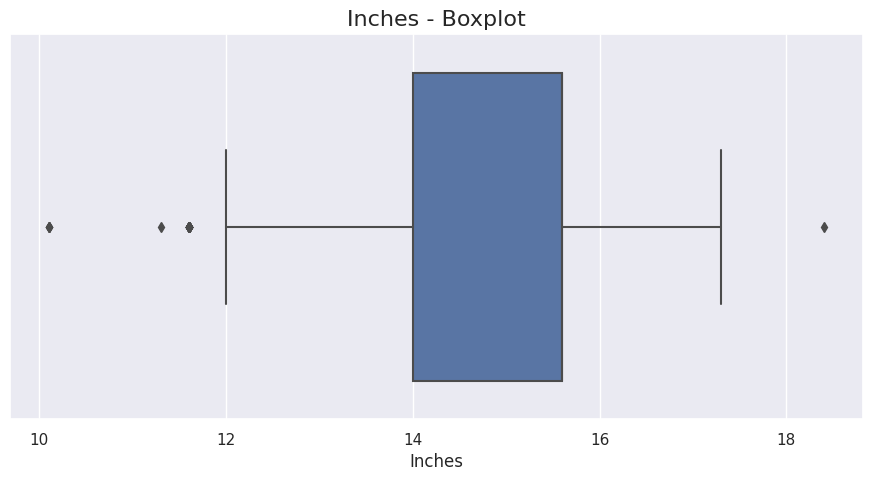

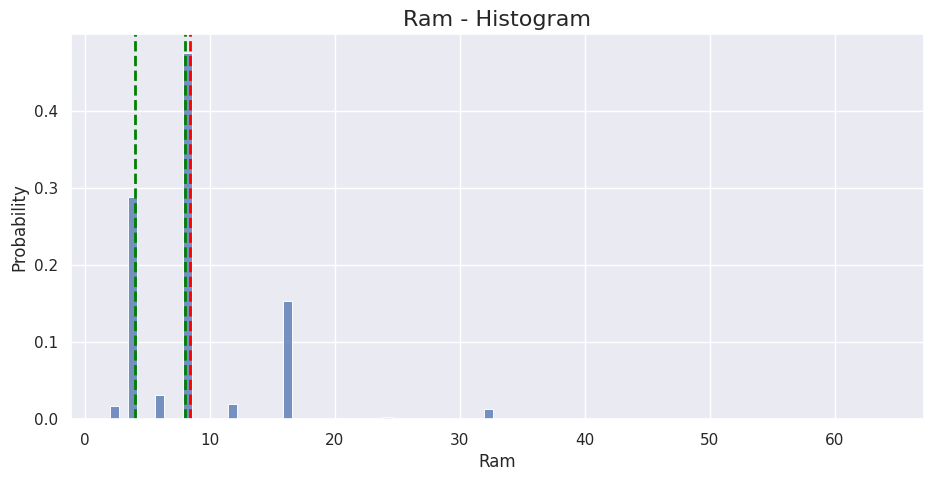

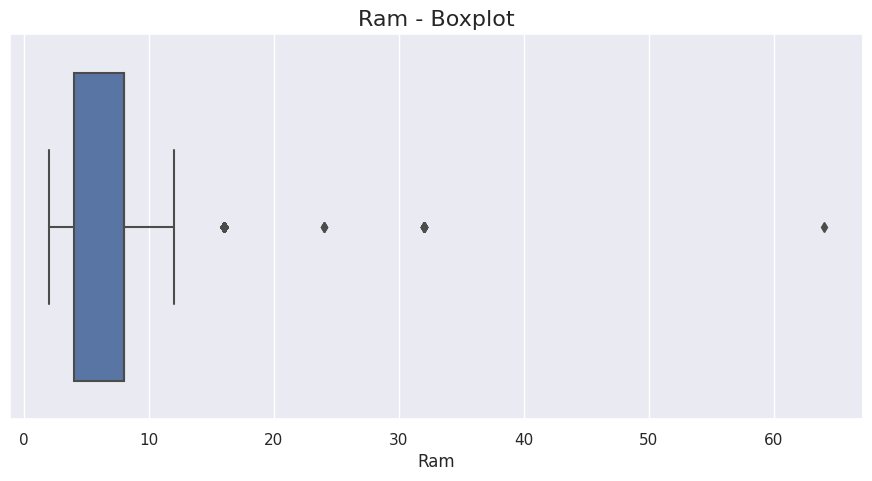

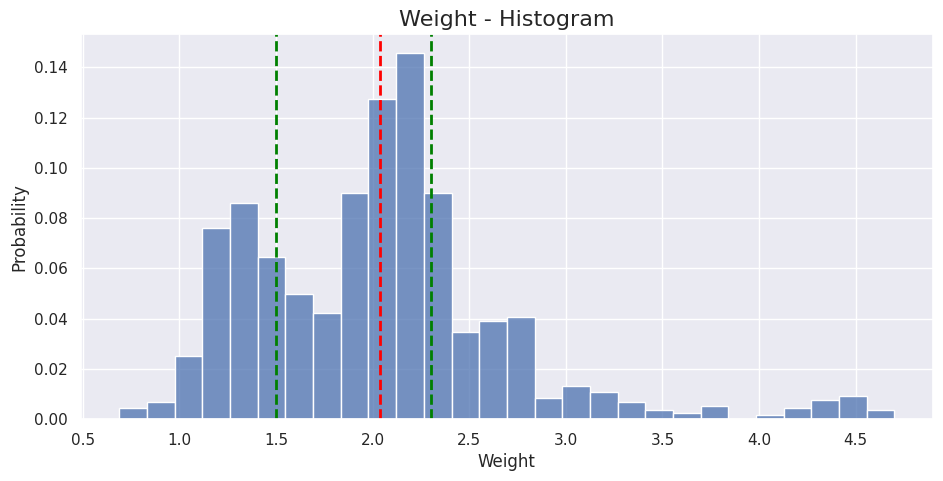

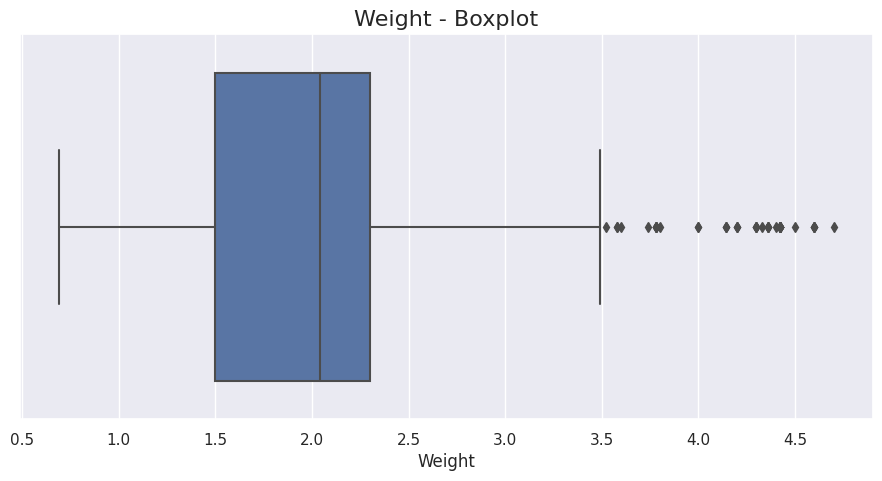

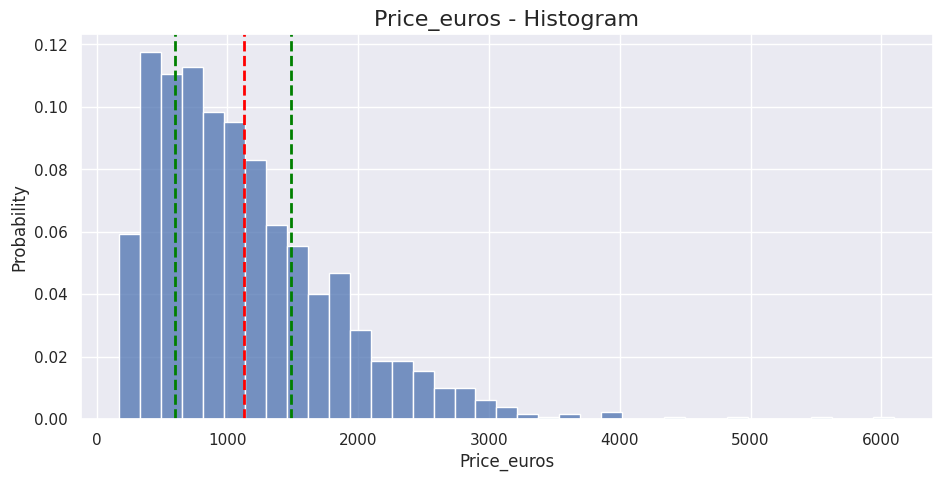

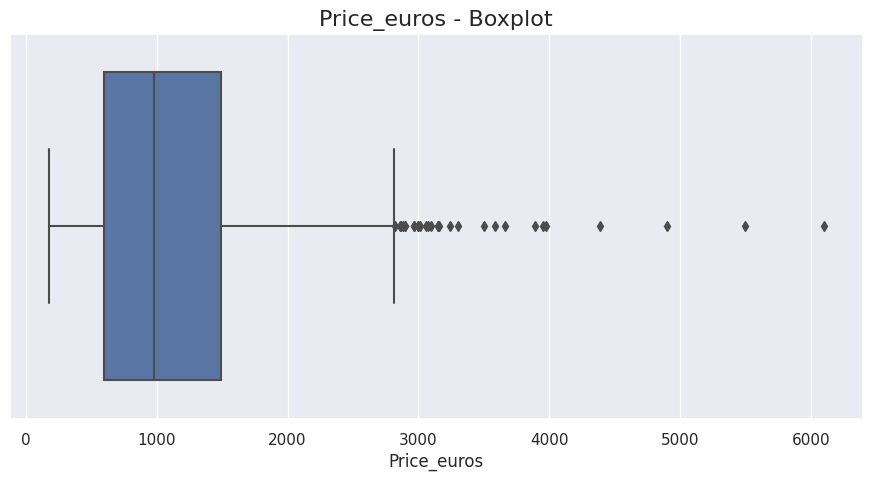

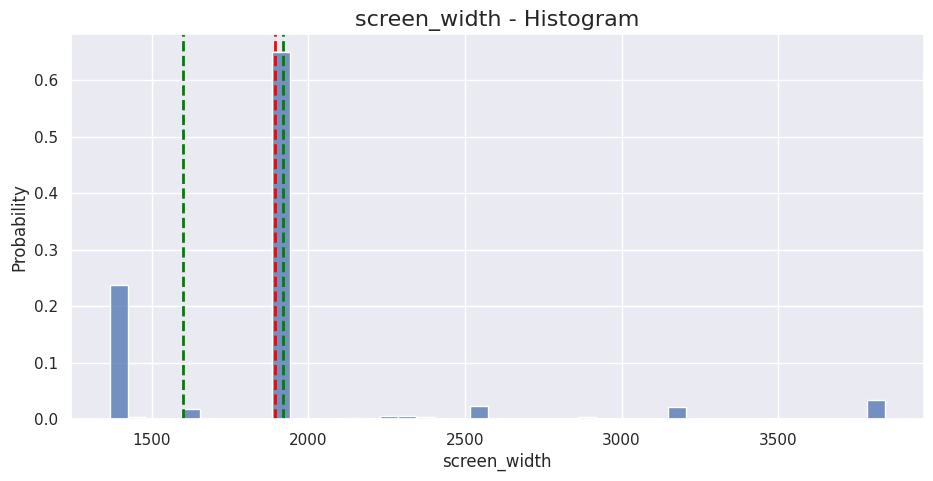

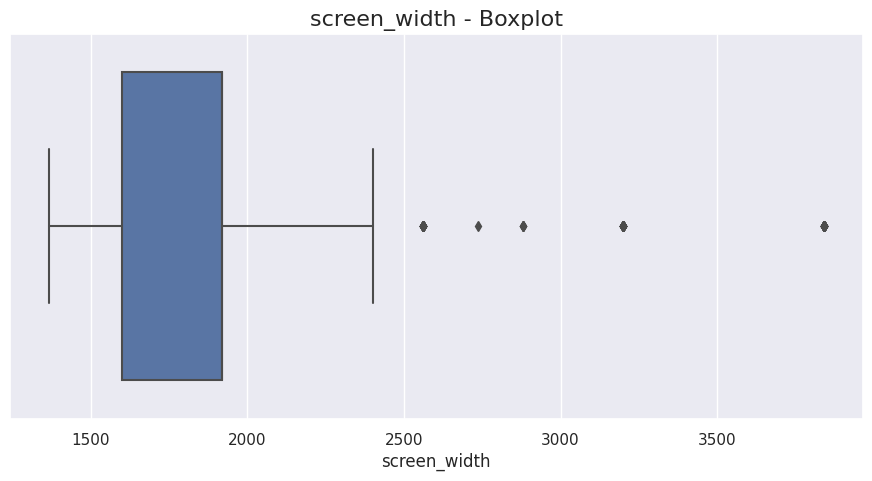

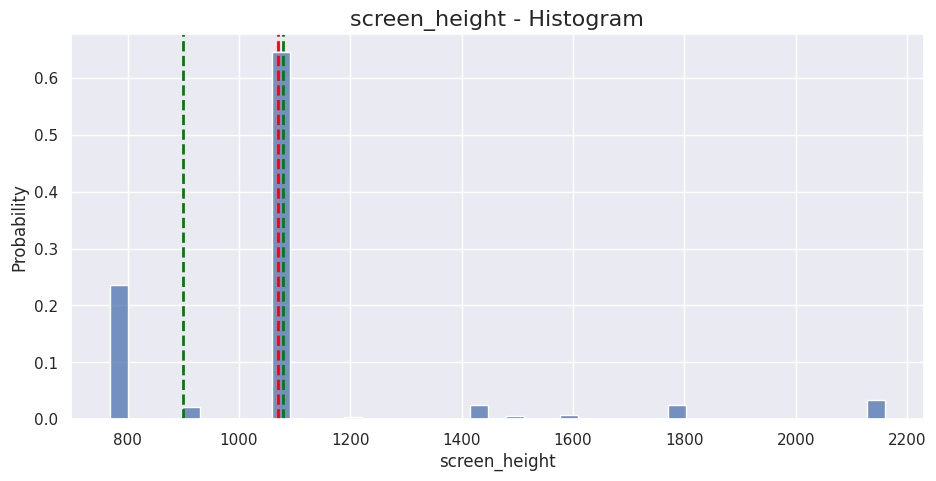

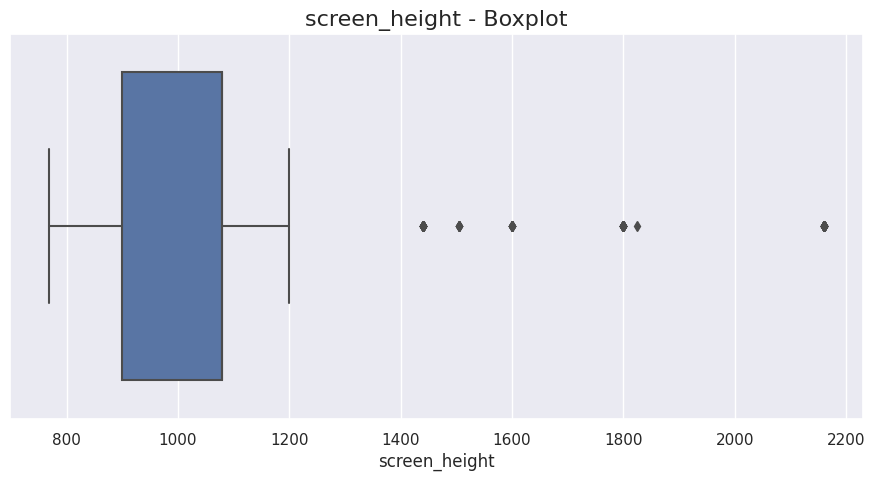

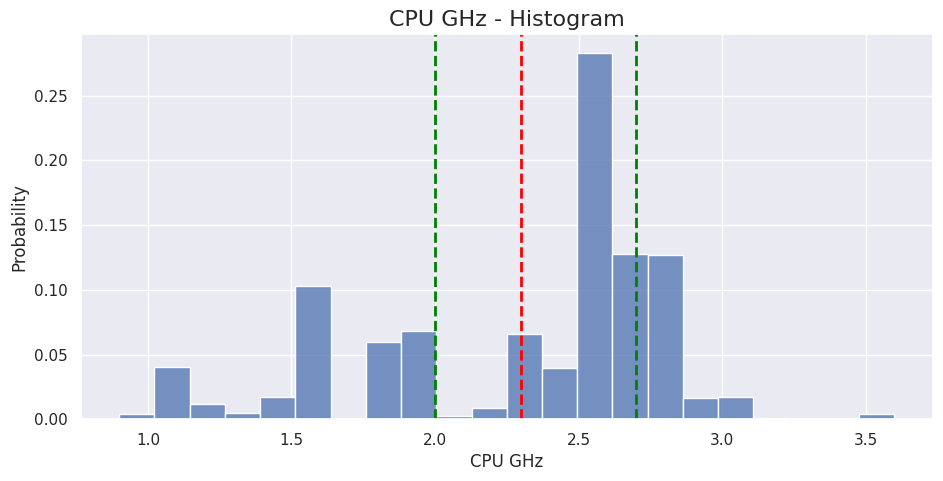

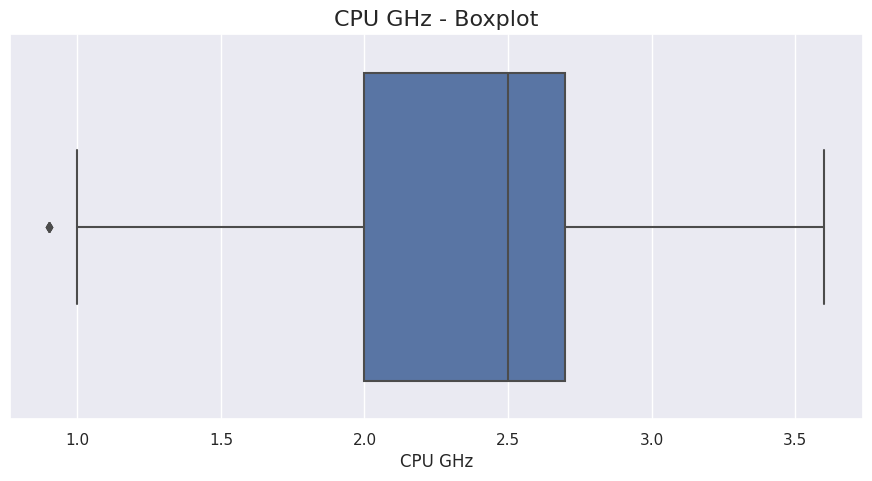

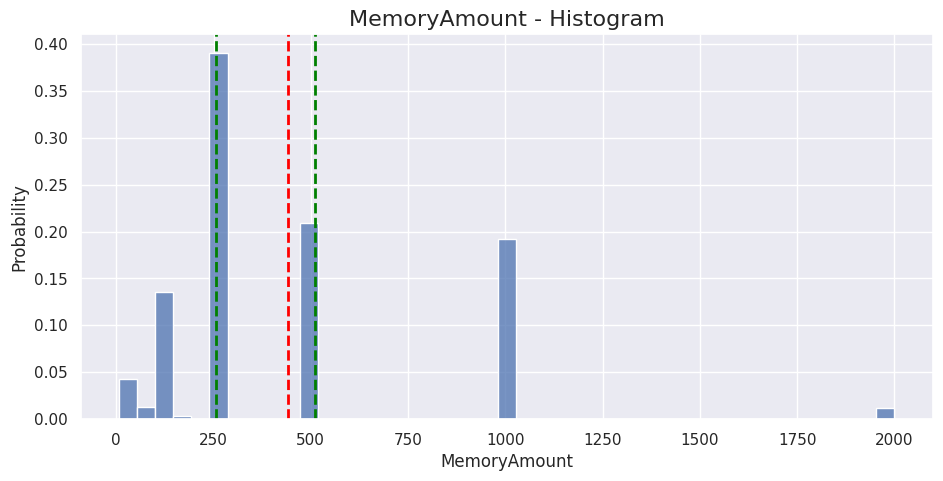

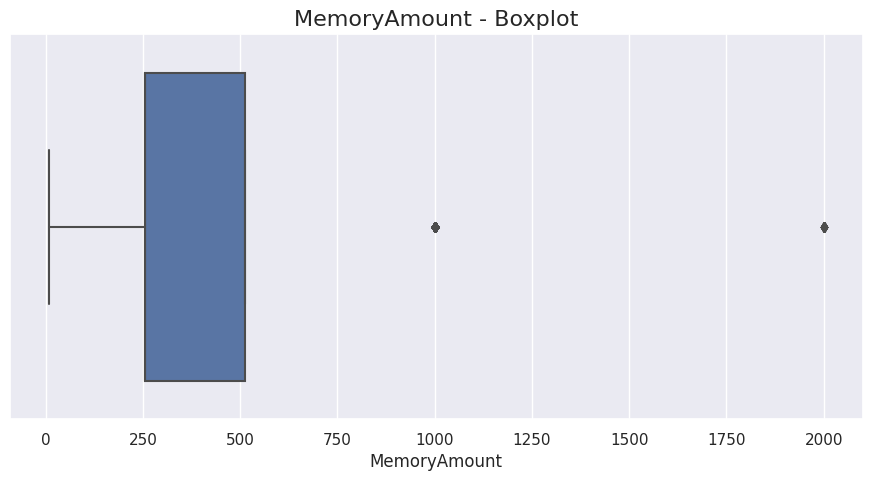

In [95]:
hist_boxplot(df=laptop)

<AxesSubplot:xlabel='Price_euros', ylabel='Probability'>

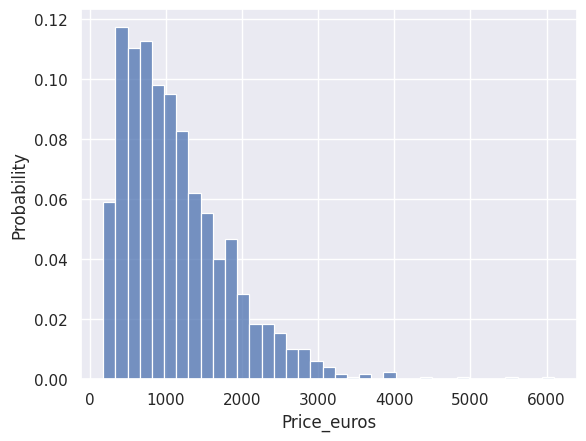

In [96]:
sns.histplot(
    data=laptop,
    x='Price_euros',
    stat='probability'
)

## Empirical cumulative probability functions and density function

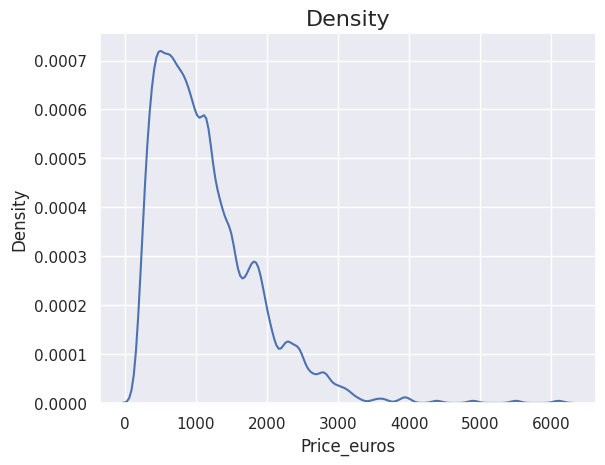

In [97]:
sns.kdeplot(
    data=laptop,
    x='Price_euros',
    bw_method=0.1
)
plt.title('Density',fontsize=Title_fontsize)
plt.show()

Text(0.5, 1.0, 'Cummulative function')

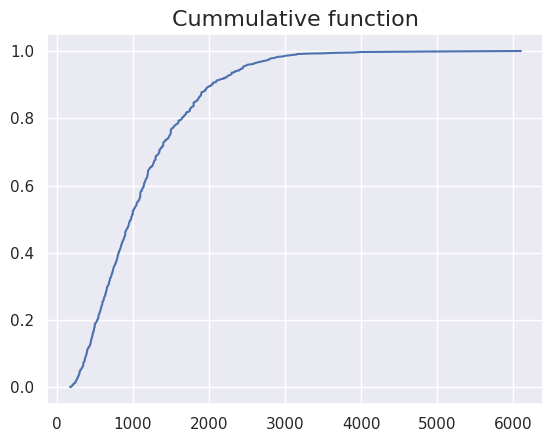

In [98]:
cmd_flipper_length=empiricaldist.Cdf.from_seq(
    laptop['Price_euros'],
    normalize=True
).plot()
plt.title('Cummulative function',fontsize=Title_fontsize)

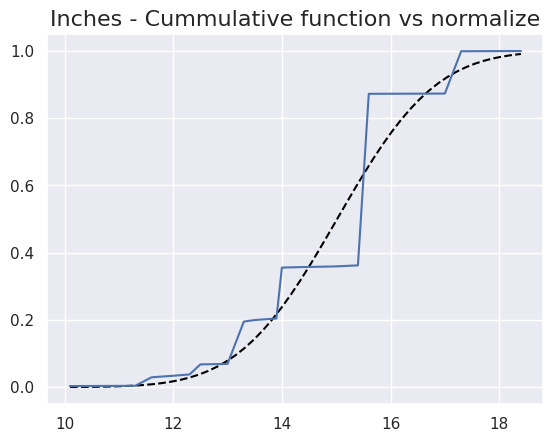

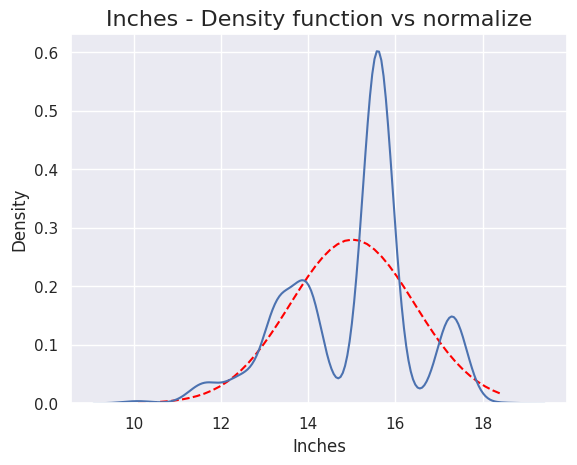

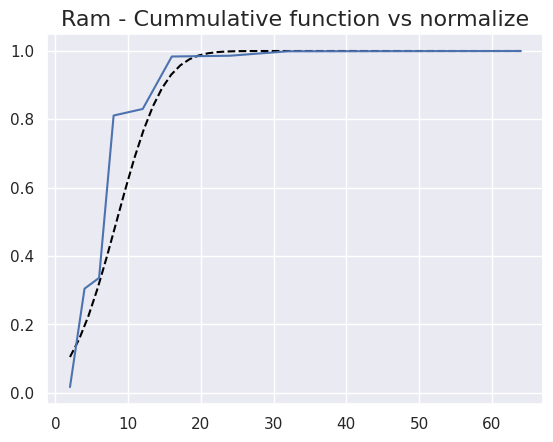

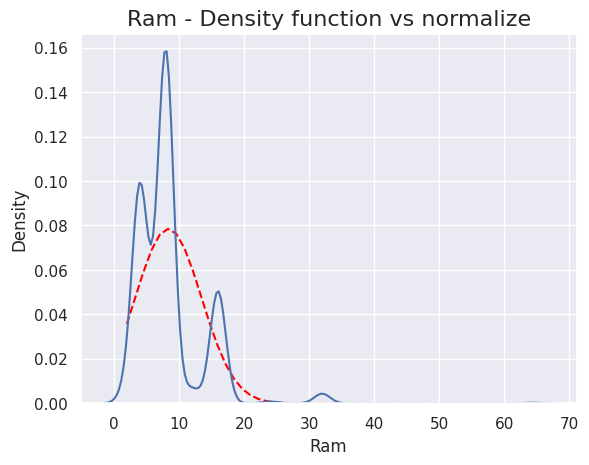

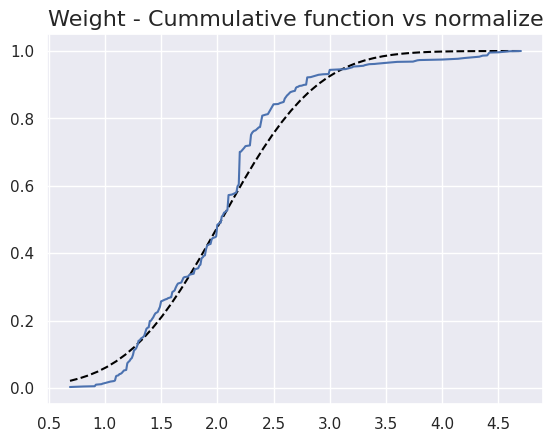

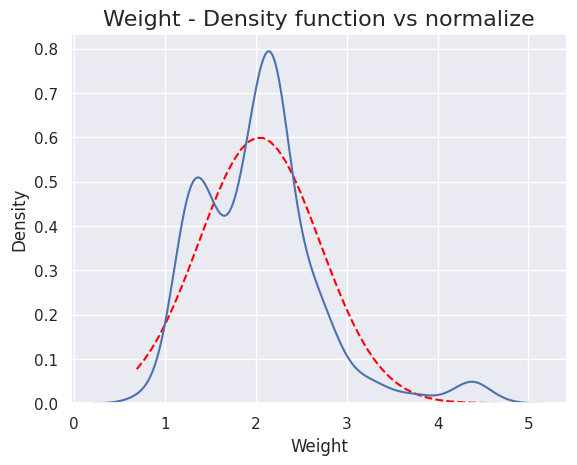

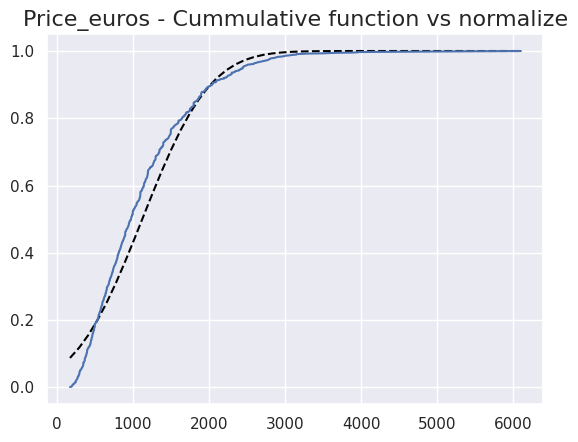

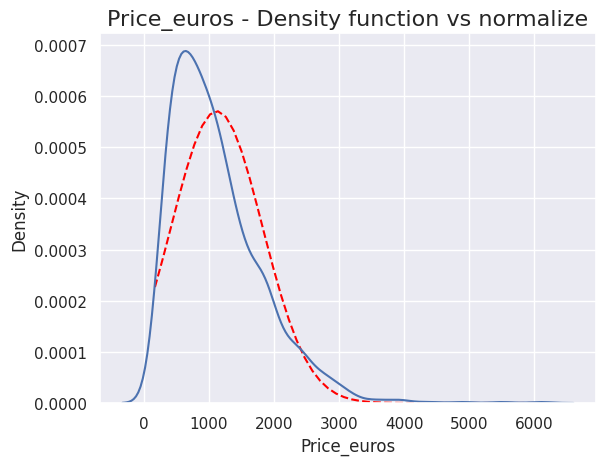

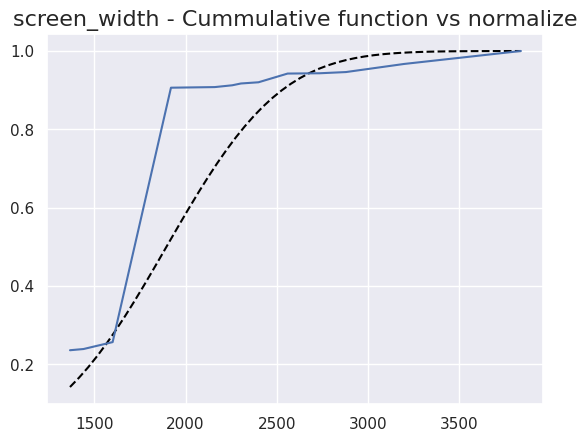

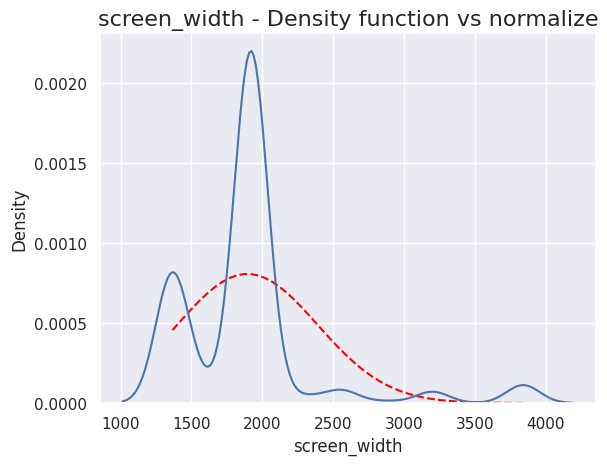

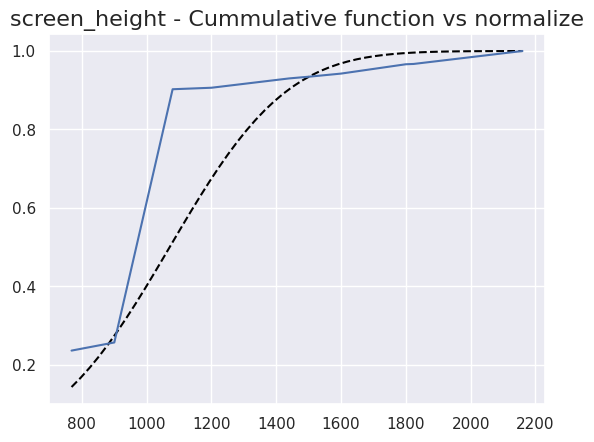

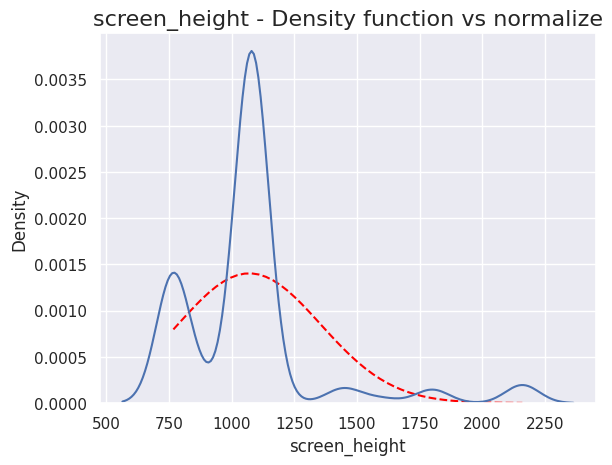

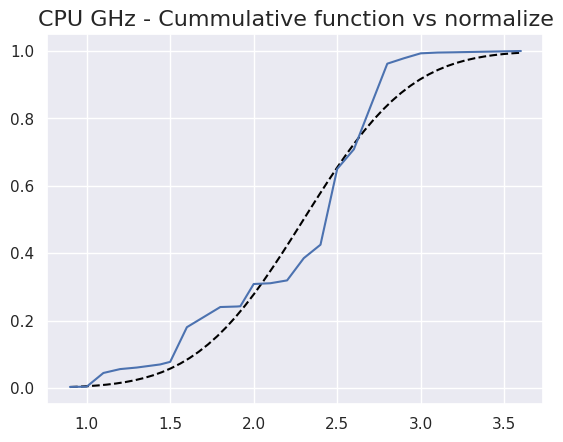

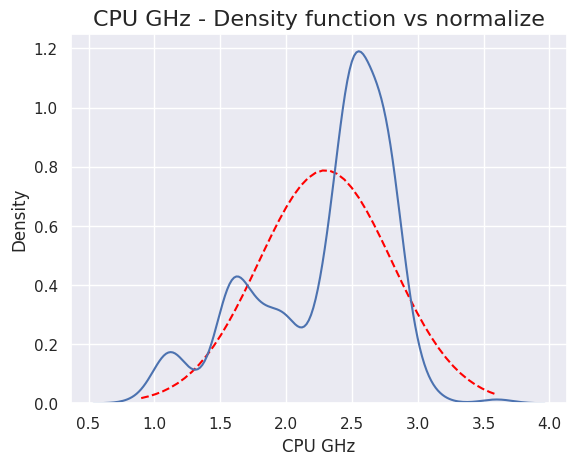

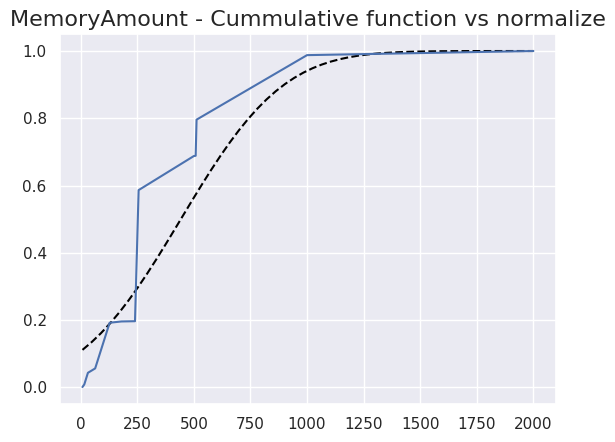

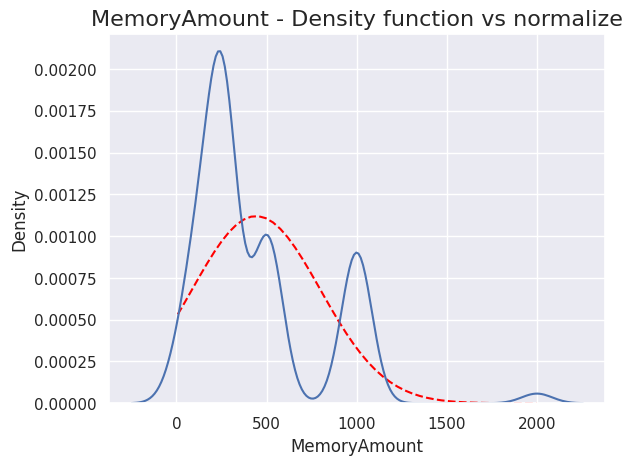

In [99]:
def NormVSReal(df):
    columns=df.select_dtypes(include=np.number)
    for column in columns:
        stats = df[column].describe()
        xs = np.linspace(stats['min'],stats['max'])
        ys= scipy.stats.norm(stats['mean'],stats['std']).cdf(xs)
        zs= scipy.stats.norm(stats['mean'],stats['std']).pdf(xs)
        
        
        plt.plot(xs,ys,color='black',linestyle='dashed')
        empiricaldist.Cdf.from_seq(
            df[column],
            normalize=True
        ).plot()
        plt.title(f'{column} - Cummulative function vs normalize',fontsize=Title_fontsize)
        plt.show()
        
        plt.plot(xs,zs,color='red',linestyle='dashed')

        sns.kdeplot(
            data=df,
            x=column
        )

        plt.title(f'{column} - Density function vs normalize',fontsize=Title_fontsize)
        plt.show()

NormVSReal(df=laptop,)

# Bivariate Analysis

In [103]:
laptop.head()

,Company,TypeName,Inches,Ram,Gpu,OpSys,Weight,Price_euros,screen_width,screen_height,IPS Panel,CPU Brand,CPU GHz,MemoryAmount,MemoryType
0,Apple,Ultrabook,13.30,8,Intel,macOS,1.37,1339.69,2560,1600,True,Intel,2.30,128,SSD
1,Apple,Ultrabook,13.30,8,Intel,macOS,1.34,898.94,1440,900,False,Intel,1.80,128,Flash
2,HP,Notebook,15.60,8,Intel,No OS,1.86,575.00,1920,1080,False,Intel,2.50,256,SSD
3,Apple,Ultrabook,15.40,16,AMD,macOS,1.83,2537.45,2880,1800,True,Intel,2.70,512,SSD
4,Apple,Ultrabook,13.30,8,Intel,macOS,1.37,1803.60,2560,1600,True,Intel,3.10,256,SSD


In [113]:
def boxplot(df,num_column):
    categories = df.select_dtypes(include='object')
    for category in categories:
        plt.figure(figsize=(12,6))
        sns.boxplot(
            data=laptop,
            x=category,
            y=num_column
        )

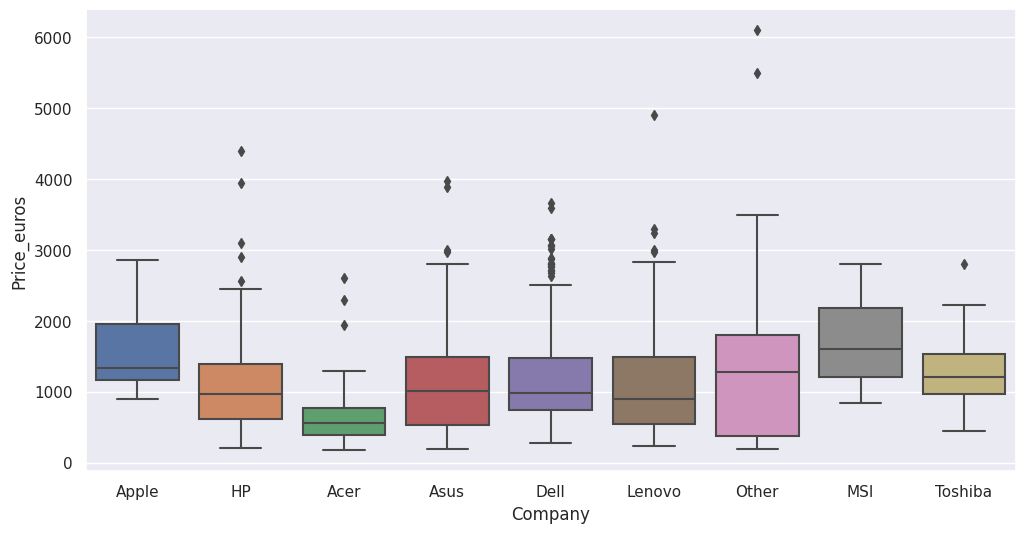

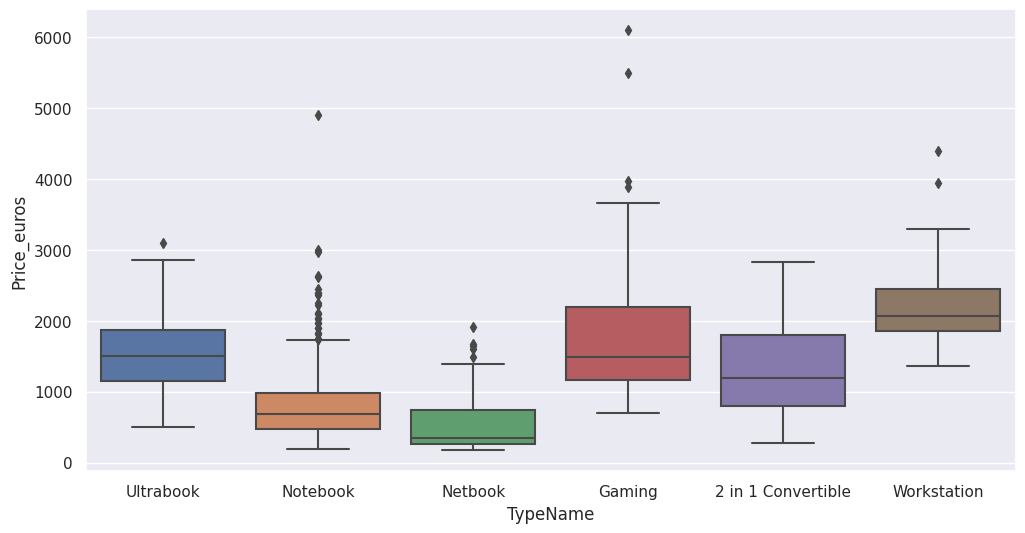

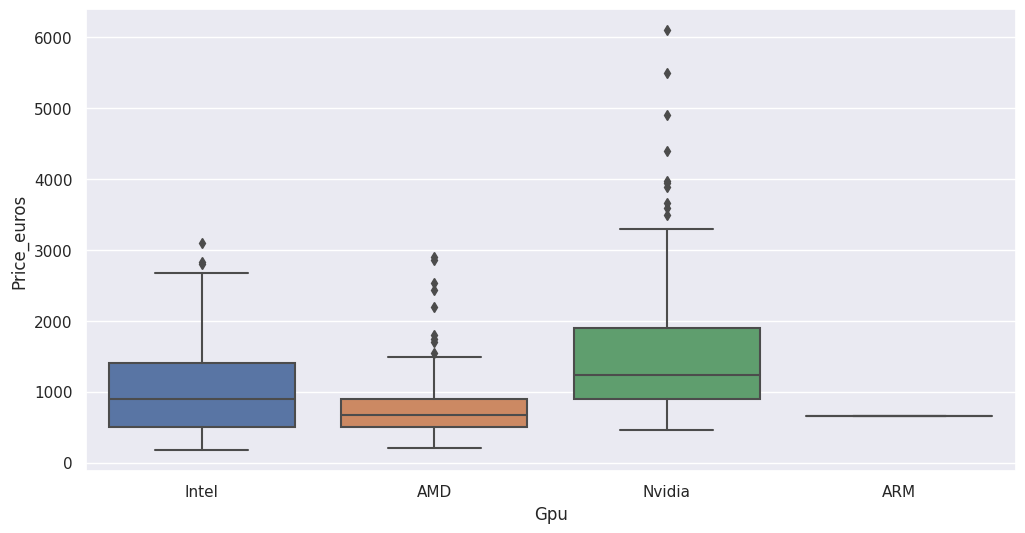

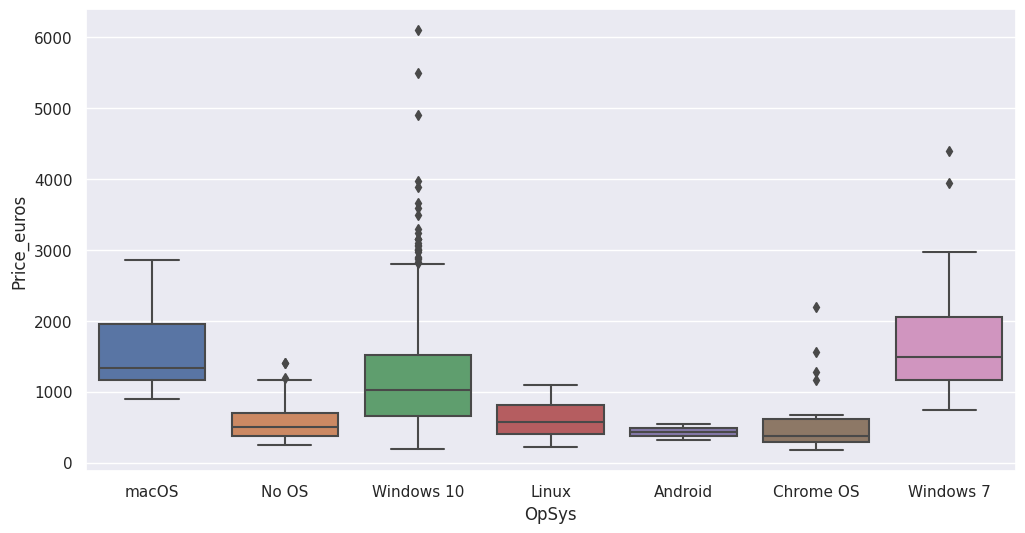

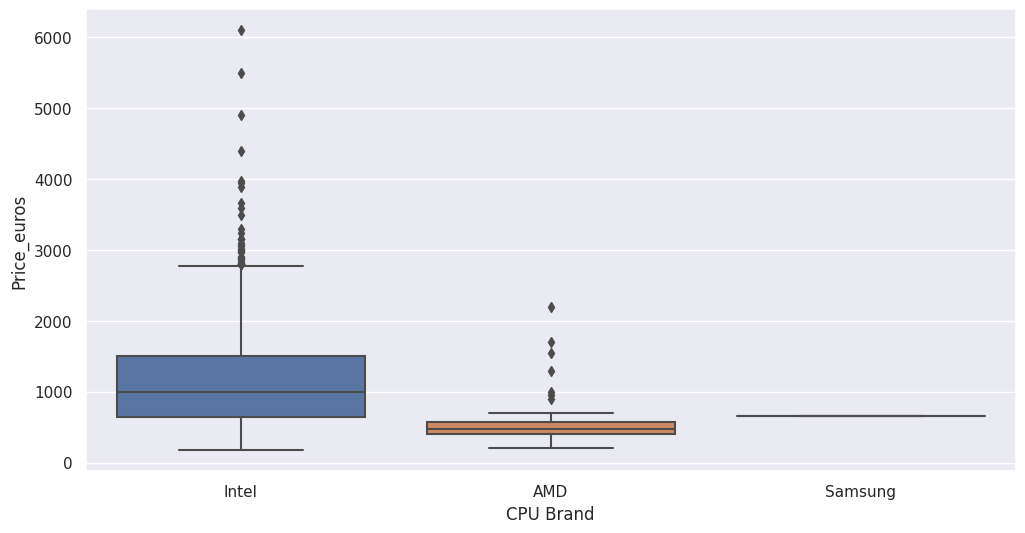

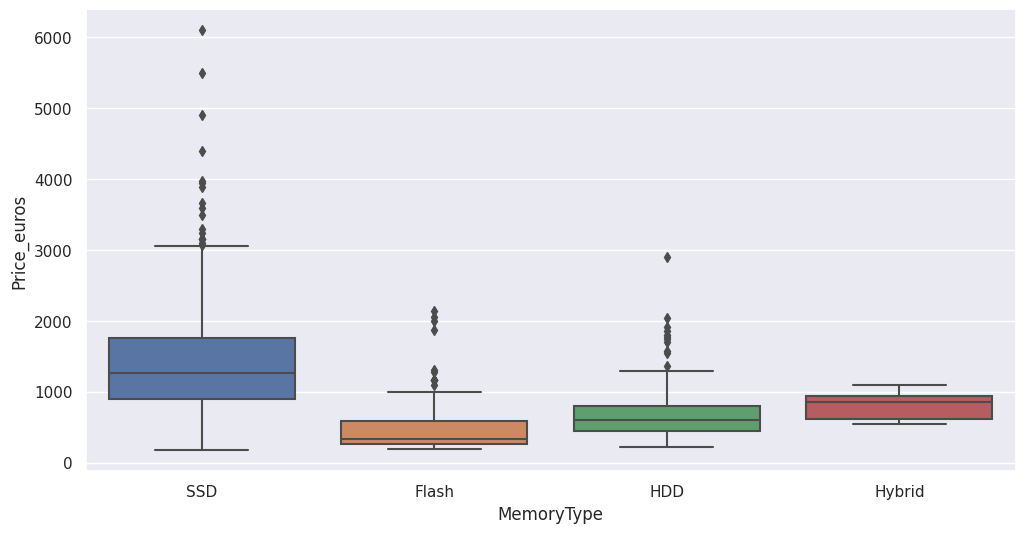

In [114]:
boxplot(df=laptop,num_column='Price_euros')

In [115]:
# This row is the only one with CPU Brand = Samsung and GPU = ARM, so it just add more noise to our analysis
laptop[laptop['CPU Brand']=='Samsung']

,Company,TypeName,Inches,Ram,Gpu,OpSys,Weight,Price_euros,screen_width,screen_height,IPS Panel,CPU Brand,CPU GHz,MemoryAmount,MemoryType
1191,Other,2 in 1 Convertible,12.30,4,ARM,Chrome OS,1.15,659.00,2400,1600,True,Samsung,2.00,32,Flash
